# Import

In [1]:
import pickle
import qiskit
import numpy as np
from qiskit_ibm_provider import IBMProvider
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info.analysis import hellinger_fidelity
import matplotlib.pyplot as plt
from scipy import stats
from qiskit.dagcircuit.dagcircuit import DAGCircuit, DAGOpNode

# from qiskit.tools.monitor import job_monitor

In [2]:
provider = IBMProvider()
backend = provider.get_backend("ibmq_guadalupe")

# Load Pickle

In [3]:
qcs, transpiled_qcs, min_qubits, max_qubits, algorithms, techniques_temp = pickle.load( open( "save_transpile_{}.pickle".format(backend.name), "rb" ) )

In [4]:
# TODO: fix this in transpilation notebook
algorithms = list(algorithms)
algorithms[algorithms.index('Bernstein_Vazirani')] = 'BV'
algorithms = tuple(algorithms)
techniques = list(techniques_temp)
techniques.insert(0, 'Tket')
techniques = tuple(techniques)
display(techniques)
del techniques_temp

('Tket', 'Qiskit Opt 0', 'Qiskit Opt 3', 'Qiskit Opt 3 Sabre')

# Run on IBM QC

In [5]:
qc_shots=4000

In [6]:
# job = backend.run(transpiled_qcs, shots=4000)
# job = fake_backend.run(tqcs, shots=1000)

# Checkpoint

In [7]:
job = provider.backend.retrieve_job('cfree93mcdu9d5vi0on0')

# Simulate QCs

In [8]:
def simulate_classically(qc_list):
    aer_sim = Aer.get_backend('aer_simulator')
    tqc_list = transpile(qc_list, aer_sim)
    job_sim = aer_sim.run(tqc_list, shots=1000)
    results = job_sim.result()
    return results

In [9]:
sim_res_counts = simulate_classically(qcs).get_counts()

# Calculate Runtimes

In [10]:
props = backend.properties()

In [11]:
def circuit_runtime_in_ms(tqc, backend):
    dag = circuit_to_dag(tqc)
    circuit_execution_time = 0
    qubits_map = {}
    for q_index, qubit in enumerate(dag.qubits):
        qubits_map[qubit] = q_index

    for s in dag.layers():
        graph: DAGCircuit = s['graph']
        gate: DAGOpNode
        max_gate_time_in_layer = 0
        for gate in graph.gate_nodes():
            q_index = [qubits_map[qarg] for qarg in gate.qargs]
            g_time = props.gate_length(gate.name, q_index)
            if g_time > max_gate_time_in_layer:
                max_gate_time_in_layer = g_time
        circuit_execution_time += max_gate_time_in_layer
    return circuit_execution_time*1000

In [12]:
circuit_run_times_in_ms = []

for tqc in job.circuits():
    circuit_run_times_in_ms.append(circuit_runtime_in_ms(tqc, backend))

In [13]:
len(circuit_run_times_in_ms)

88

In [14]:
def calculate_avg_cx_errors(backend):
    cx_gates = [g for g in backend.properties().gates if g.gate == 'cx']
    cx_error_rate = 0
    for g in cx_gates:    
        cx_error_rate += g.parameters[0].value

    avg_cx_error_rate = cx_error_rate /len(cx_gates)
    return avg_cx_error_rate

In [15]:
avg_cx_error_rate = calculate_avg_cx_errors(backend)
print('avg_cx_error_rate: ', avg_cx_error_rate)

avg_cx_error_rate:  0.009867675173251031


In [16]:
qc_res_counts = job.result().get_counts()

In [17]:
cx_counts = []
for tqc in job.circuits():
    cx_counts.append(tqc.count_ops()['cx'])

# Calculate Fidelities

In [18]:
fidelities = []
n_s = max_qubits-min_qubits+1

for al_index, al_name in enumerate(algorithms):
    for n_index in range(n_s):
        n = n_index + min_qubits
        sim_res_counts_n = sim_res_counts[al_index*(n_s) + n_index]
        for t_index, t_name in enumerate(techniques):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            qc_counts = qc_res_counts[tqc_index]
            hf = hellinger_fidelity(sim_res_counts_n, qc_counts)
            fidelities.append(hf)

# Results

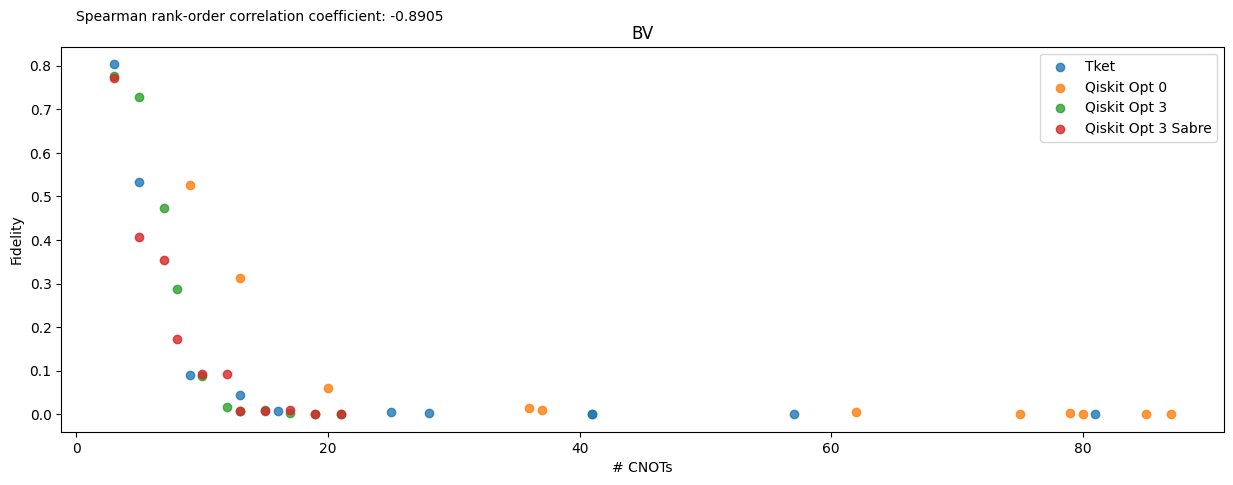

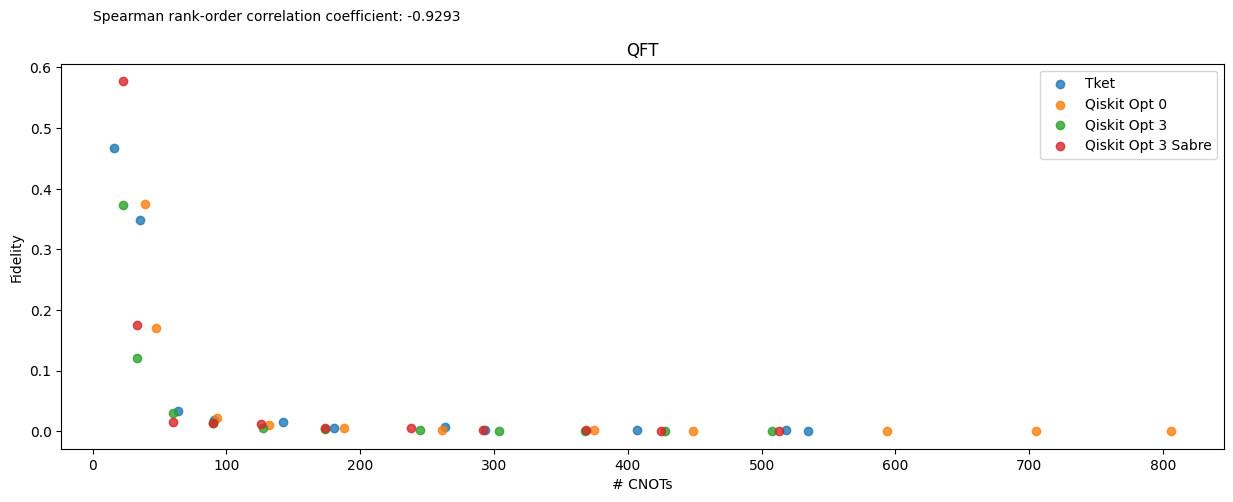

In [19]:
# fidelity vs no of cnots


for al_index, al_name in enumerate(algorithms):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set(xlabel='# CNOTs', ylabel='Fidelity', title=al_name)
    x2 = []
    y2 = []
    for t_index, t_name in enumerate(techniques):
        x = []
        y = []
        for n_index in range(n_s):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            x.append(cx_counts[tqc_index])
            y.append(fidelities[tqc_index])
        ax.scatter(x, y, label = t_name, alpha=0.8)
        ax.legend()
        x2.extend(x)
        y2.extend(y)
    res = stats.spearmanr(x2, y2)
    ax.text(0, max(y2)+0.1, 'Spearman rank-order correlation coefficient: {:2.4f}'.format(res.statistic))
    plt.show(fig)

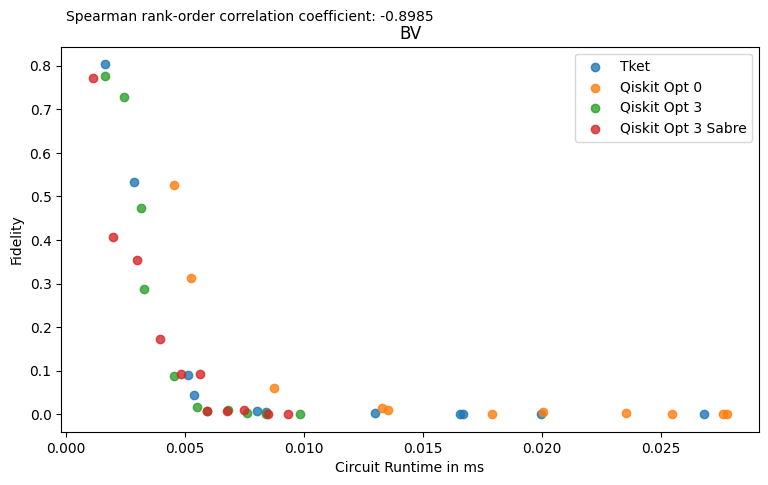

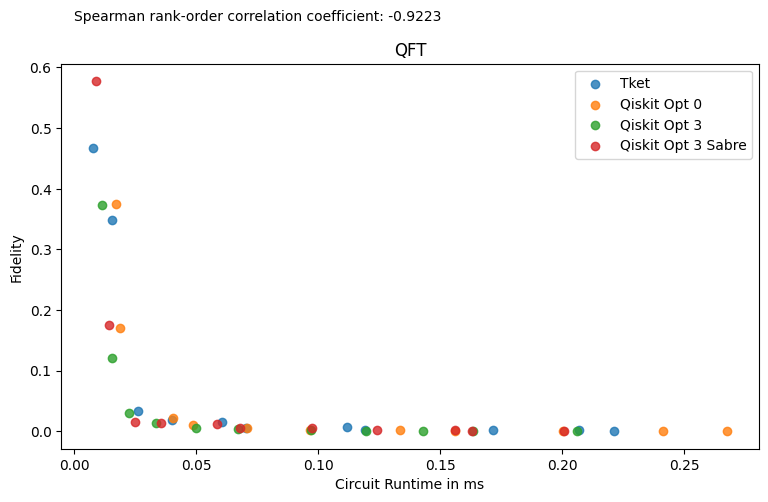

In [20]:
# fidelity vs no of runtime


for al_index, al_name in enumerate(algorithms):
    fig, ax = plt.subplots(figsize=(9,5))
    ax.set(xlabel='Circuit Runtime in ms', ylabel='Fidelity', title=al_name)
    x2 = []
    y2 = []
    for t_index, t_name in enumerate(techniques):
        x = []
        y = []
        for n_index in range(n_s):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            x.append(circuit_run_times_in_ms[tqc_index])
            y.append(fidelities[tqc_index])
        ax.scatter(x, y, label = t_name, alpha=0.8)
        ax.legend()
        x2.extend(x)
        y2.extend(y)
    res = stats.spearmanr(x2, y2)
    ax.text(0, max(y2)+0.1, 'Spearman rank-order correlation coefficient: {:2.4f}'.format(res.statistic))
    plt.show(fig)

# Local Readout Mitigation

In [21]:
from qiskit.result import LocalReadoutMitigator, CorrelatedReadoutMitigator

In [22]:
mitigated_fidelities = []
n_s = max_qubits-min_qubits+1

for al_index, al_name in enumerate(algorithms):
    for n_index in range(n_s):
        n = n_index + min_qubits
        sim_res_counts_n = sim_res_counts[al_index*(n_s) + n_index]
        for t_index, t_name in enumerate(techniques):
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            tqc = transpiled_qcs[tqc_index]
            qubits_map = {}
            for q_index, qubit in enumerate(tqc.qubits):
                qubits_map[qubit] = q_index 
            qubit_indices = []
            for d in tqc.data:
                inst, qarg, carg = d
                if inst.name != 'measure':
                    continue
                qubit_indices.append(qubits_map[qarg[0]])
            local_mitigator = LocalReadoutMitigator(backend=backend, qubits=qubit_indices)
            mitigated_quasi_probs = local_mitigator.quasi_probabilities(data=qc_res_counts[tqc_index])
            mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())


            hf = hellinger_fidelity(sim_res_counts_n, mitigated_probs)
            mitigated_fidelities.append(hf)

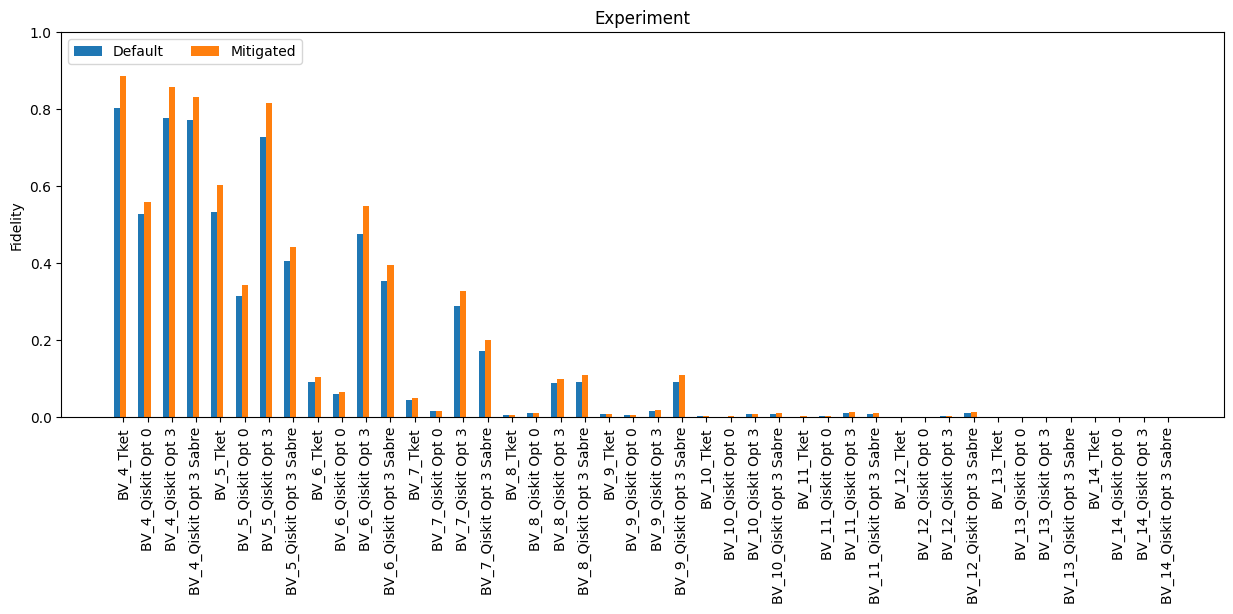

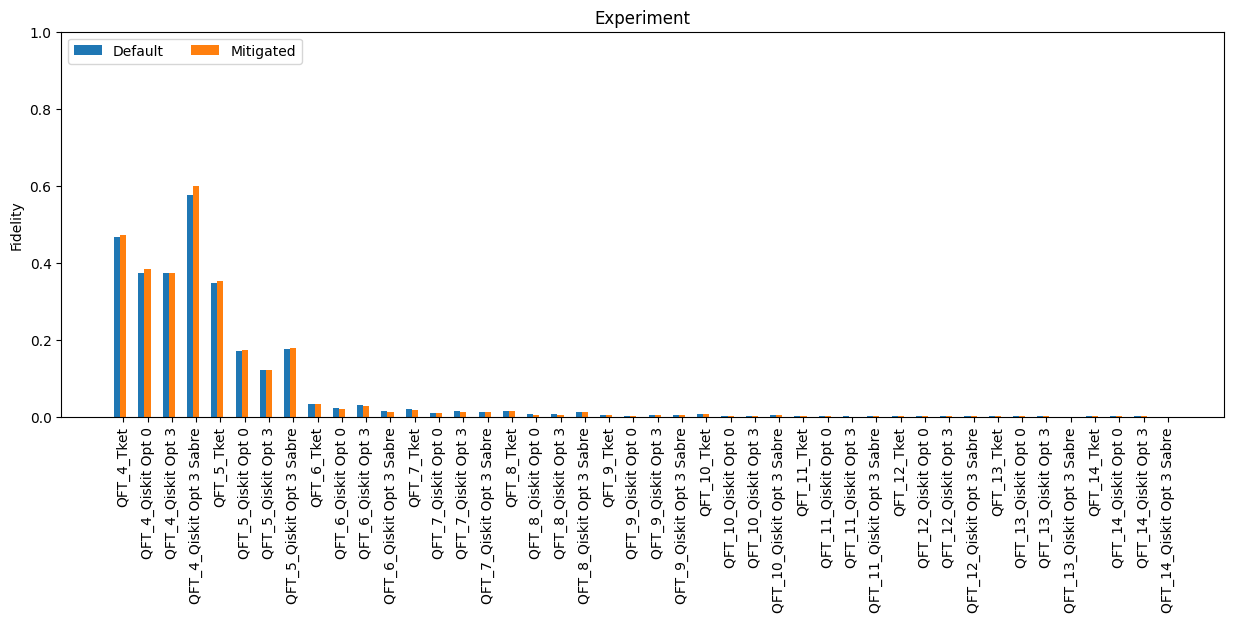

In [23]:
for al_index, al_name in enumerate(algorithms):
    species = []
    data = {
        'Default': [],
        'Mitigated': []
    }
    for n_index in range(n_s):
        n = n_index + min_qubits
        for t_index, t_name in enumerate(techniques):
            species.append('{}_{}_{}'.format(al_name, n,t_name))
            tqc_index = al_index*(n_s)*len(techniques) + n_index*len(techniques) + t_index
            data['Default'].append(fidelities[tqc_index])
            data['Mitigated'].append(mitigated_fidelities[tqc_index])

    x = np.arange(len(species))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(figsize=(15,5))

    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Fidelity')
    ax.set_title('Experiment')
    ax.set_xticks(x + width, species, rotation='vertical')
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1)
    plt.show()

# Test

## Naive Readout mitigation

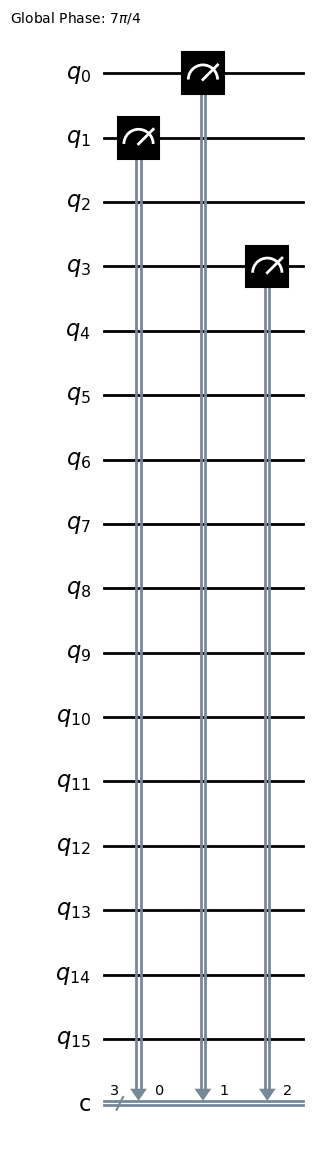

In [24]:
dag = circuit_to_dag(transpiled_qcs[1])
circuit_execution_time = 0
qubits_map = {}
for q_index, qubit in enumerate(dag.qubits):
    qubits_map[qubit] = q_index

for op, _ in dag.count_ops().items():
    if op != 'measure':
        dag.remove_all_ops_named(op)

dag_to_circuit(dag).draw('mpl')